In [7]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from dubins_planner import DubinsPath

In [9]:
class Node:
    def __init__(self, x, y, yaw):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0
        self.yaw = yaw
        self.path_yaw = []

In [10]:
class RRTStarDubins:
    def __init__(self, start, goal, obstacle_list, rand_area,
                 goal_sample_rate=10,
                 max_iter=100,
                 connect_circle_dist=50.0,
                 robot_radius=0.0,
                 ):

        self.start = Node(start[0], start[1], start[2])
        self.end = Node(goal[0], goal[1], goal[2])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist

        self.curvature = 1.0  # for dubins path
        self.goal_yaw_th = np.deg2rad(1.0)
        self.goal_xy_th = 0.5
        self.robot_radius = robot_radius
        self.dubbins_planner = DubinsPath()

    def planning(self, search_until_max_iter=True):

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd)

            if self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                near_indexes = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indexes)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_indexes)

            if (not search_until_max_iter) and new_node:  # check reaching the goal
                last_index = self.search_best_goal_node()
                if last_index:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index:
            return self.generate_final_course(last_index)
        else:
            print("Cannot find path")

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):

        goal_indexes = []
        for (i, node) in enumerate(self.node_list):
            if self.calc_dist_to_goal(node.x, node.y) <= self.goal_xy_th:
                goal_indexes.append(i)

        # angle check
        final_goal_indexes = []
        for i in goal_indexes:
            if abs(self.node_list[i].yaw - self.end.yaw) <= self.goal_yaw_th:
                final_goal_indexes.append(i)

        if not final_goal_indexes:
            return None

        min_cost = min([self.node_list[i].cost for i in final_goal_indexes])
        for i in final_goal_indexes:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """"""  """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt(np.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])

    def calc_new_cost(self, from_node, to_node):

        _, _, _, _, course_lengths = self.dubbins_planner.plan_dubins_path(
            from_node.x, from_node.y, from_node.yaw,
            to_node.x, to_node.y, to_node.yaw, self.curvature)

        cost = sum([abs(c) for c in course_lengths])

        return from_node.cost + cost

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

    def steer(self, from_node, to_node):

        px, py, pyaw, mode, course_lengths = \
            self.dubbins_planner.plan_dubins_path(
                from_node.x, from_node.y, from_node.yaw,
                to_node.x, to_node.y, to_node.yaw, self.curvature)

        if len(px) <= 1:  # cannot find a dubins path
            return None

        new_node = copy.deepcopy(from_node)
        new_node.x = px[-1]
        new_node.y = py[-1]
        new_node.yaw = pyaw[-1]

        new_node.path_x = px
        new_node.path_y = py
        new_node.path_yaw = pyaw
        new_node.cost += sum([abs(c) for c in course_lengths])
        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_index):
        print("final")
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_index]
        while node.parent:
            for (ix, iy) in zip(reversed(node.path_x), reversed(node.path_y)):
                path.append([ix, iy])
            node = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):

        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(-np.pi, np.pi)
                       )
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y, self.end.yaw)

        return rnd

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

In [11]:
np.random.seed(13)

obstacleList = [
    (5.5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
]  # [x,y,size(radius)]

# Set Initial parameters
start = [0.0, 0.0, np.deg2rad(10.0)]
goal = [10.0, 10.0, np.deg2rad(0.0)]

rnd_min = 0
rnd_max= 15

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[rnd_min, rnd_max], obstacle_list=obstacleList, robot_radius=0.5)
path = rrtstar_dubins.planning(search_until_max_iter=False)


Iter: 0 , number of nodes: 1
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]
0.73473871801718
14.09833051280449
1.5599114285546363
[[ 0.98480775  0.17364818]
 [-0.17364818  0.98480775]]
Iter: 1 , number of nodes: 1
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]
0.2619383242965707
15.591616823100903
0.24866275038433505
[[ 0.98480775  0.17364818]
 [-0.17364818  0.98480775]]
Iter: 2 , number of nodes: 1
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]
0.35764800359558624
11.867185975397964
1.5353091440201077
[[ 0.98480775  0.17364818]
 [-0.17364818  0.98480775]]
Iter: 3 , number of nodes: 1
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]
0.40152681545026514
3.1516918489395747
2.4704739584824136
[[ 0.98480775  0.17364818]
 [-0.17364818  0.98480775]]
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.98480775]]
0.40152681545026514
3.1516918489395755
2.4704739584824136
[[ 0.98480775  0.17364818]
 [-0.17364818  0.98480775]]
[[ 0.98480775 -0.17364818]
 [ 0.17364818  0.9848

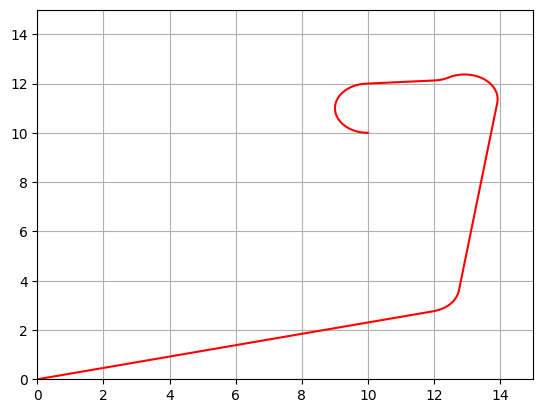

In [19]:
# rrtstar_dubins.draw_graph()
plt.xlim(rnd_min,rnd_max)
plt.ylim(rnd_min,rnd_max)
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
# plt.scatter([x for (x, y) in path], [y for (x, y) in path])
plt.grid(True)
plt.show()

In [17]:
path

[[10.0, 10.0],
 [9.999999999999998, 9.999999999999998],
 [9.821407444897595, 10.016076883459892],
 [9.724071257343468, 10.038821905692817],
 [9.629492058576048, 10.071170701720822],
 [9.538614852685695, 10.112800053067089],
 [9.452347654673655, 10.163294013013797],
 [9.371552417866317, 10.222148062604244],
 [9.297036421562508, 10.288774151629482],
 [9.229544204965583, 10.362506574231634],
 [9.169750127993815, 10.442608620416753],
 [9.118251633299012, 10.528279937017572],
 [9.075563276817029, 10.618664524557792],
 [9.042111586494936, 10.71285929011588],
 [9.018230800564776, 10.809923070731031],
 [9.00415952794562, 10.90888603719236],
 [9.000038364142137, 11.008759384251789],
 [9.005908486460777, 11.108545210439242],
 [9.021711242579736, 11.207246488764264],
 [9.047288736583567, 11.303877028680134],
 [9.082385406606983, 11.397471329773822],
 [9.126650578324526, 11.487094228726964],
 [9.179641968772511, 11.57185024315861],
 [9.240830105494211, 11.650892518989174],
 [9.309603616853611, 11.

In [1]:
import numpy as np
from dubins_planner import DubinsPath

In [2]:
dubins = DubinsPath()

In [3]:
start_x = 1.0  # [m]
start_y = 1.0  # [m]
start_yaw = np.deg2rad(45.0)  # [rad]

end_x = -3.0  # [m]
end_y = -3.0  # [m]
end_yaw = np.deg2rad(-45.0)  # [rad]

curvature = 1.0

path_x, path_y, path_yaw, mode, lengths = dubins.plan_dubins_path(start_x,
                                                            start_y,
                                                            start_yaw,
                                                            end_x,
                                                            end_y,
                                                            end_yaw,
                                                            curvature)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [13]:
cpp_path_x = [1 , 1.07413 , 1.15458 , 1.24055 , 1.33118 , 1.42557 , 1.52277 , 1.62181 , 1.72171 , 1.82146 , 1.92007 , 2.01654 , 2.10993 , 2.1993 , 2.28374 , 2.36242 , 2.43456 , 2.49943 , 2.55638 , 2.60484 , 2.64434 , 2.67447 , 2.69493 , 2.70553 , 2.70615 , 2.69678 , 2.67753 , 2.64859 , 2.61023 , 2.25 , 2.16602 , 2.08203 , 1.99805 , 1.91407 , 1.83009 , 1.74611 , 1.66213 , 1.57815 , 1.49417 , 1.41019 , 1.32621 , 1.24223 , 1.15825 , 1.07427 , 0.990289 , 0.906308 , 0.822328 , 0.738347 , 0.654367 , 0.570386 , 0.486406 , 0.402426 , 0.318445 , 0.234465 , 0.150484 , 0.0665037 , -0.0174768 , -0.101457 , -0.185438 , -0.269418 , -0.353399 , -0.437379 , -0.52136 , -0.60534 , -0.68932 , -0.773301 , -0.857281 , -0.941262 , -1.02524 , -1.10922 , -1.1932 , -1.27718 , -1.36116 , -1.44514 , -1.52912 , -1.61311 , -1.75 , -1.83656 , -1.92767 , -2.02243 , -2.11989 , -2.21909 , -2.31902 , -2.41869 , -2.5171 , -2.61327 , -2.70624 , -2.79508 , -2.8789 , -3]
cpp_path_y = [1 , 0.93294 , 0.873615 , 0.822618 , 0.780458 , 0.747557 , 0.724244 , 0.710751 , 0.707213 , 0.713666 , 0.730046 , 0.756187 , 0.79183 , 0.836618 , 0.890104 , 0.951753 , 1.02095 , 1.097 , 1.17915 , 1.26657 , 1.3584 , 1.45371 , 1.55155 , 1.65094 , 1.7509 , 1.85042 , 1.9485 , 2.04418 , 2.13649 , 2.54691 , 2.6012 , 2.65549 , 2.70978 , 2.76407 , 2.81836 , 2.87264 , 2.92693 , 2.98122 , 3.03551 , 3.0898 , 3.14409 , 3.19838 , 3.25267 , 3.30696 , 3.36124 , 3.41553 , 3.46982 , 3.52411 , 3.5784 , 3.63269 , 3.68698 , 3.74127 , 3.79556 , 3.84984 , 3.90413 , 3.95842 , 4.01271 , 4.067 , 4.12129 , 4.17558 , 4.22987 , 4.28416 , 4.33844 , 4.39273 , 4.44702 , 4.50131 , 4.5556 , 4.60989 , 4.66418 , 4.71847 , 4.77276 , 4.82704 , 4.88133 , 4.93562 , 4.98991 , 5.0442 , 5.1327 , 5.1827 , 5.22381 , 5.25562 , 5.27782 , 5.29017 , 5.29255 , 5.28495 , 5.26744 , 5.24018 , 5.20347 , 5.15765 , 5.1032 , 5]

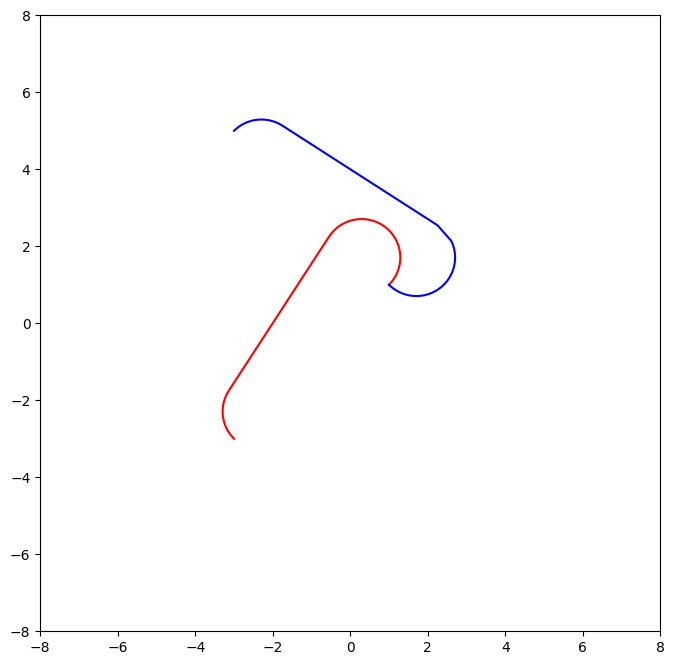

In [21]:
plt.figure(figsize=(8,8))
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.plot(path_x, path_y, 'r')
plt.plot(cpp_path_x, cpp_path_y, 'b')